<font color='red' size="50px"> Face Expression Detection Using CNN </font>
====================================

<img src="https://www.scienceofpeople.com/wp-content/uploads/2020/07/778260_Microexpressions_072120-1024x597.jpg">

## Installing and importing all the libraries required

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
#from livelossplot import PlotLossesTensorFlowKeras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


## Plotting Sample images

In [2]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("train/"):
        print(expression + ":")
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("train/" + expression + "/" +os.listdir("train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

angry:
disgust:
fear:
happy:
neutral:
sad:
surprise:


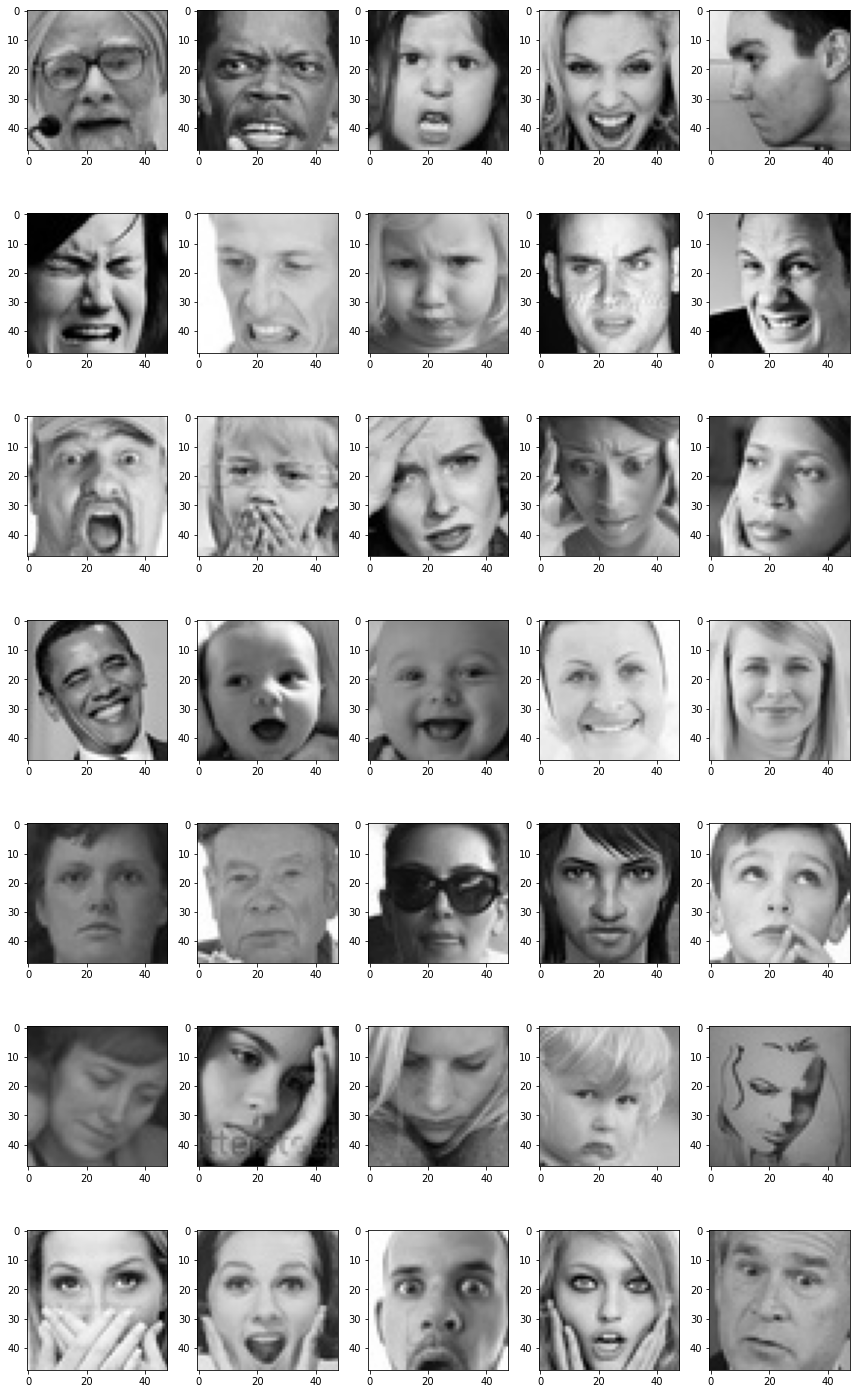

In [3]:
# Plotting 5 images of each facial expression in the train dataset
plot_example_images(plt).show()

In [4]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


## Data Augmentation

### Generate Training and validation batches

In [5]:
img_size =48
batch_size = 64

# Datagenerator object for training set train :
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_gen = datagen_train.flow_from_directory("train/",target_size =(img_size,img_size),color_mode='grayscale',
                                             batch_size = batch_size, class_mode = 'categorical',shuffle= True)

# Validation datagenerator 
datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_gen = datagen_train.flow_from_directory("test/",target_size =(img_size,img_size),color_mode='grayscale',
                                             batch_size = batch_size, class_mode = 'categorical',shuffle= True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Creating CNN Model

In [6]:
model = Sequential()

#First Convolutional Layer - Conv Layer 1
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))  #Input Image Shape=48x48 and type= grayscale
model.add(BatchNormalization())
model.add(Activation('relu')) #non linearility
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # to prevent overfitting

#Second Convolutional Layer - Conv Layer 2
# Increasing the number of filters
model.add(Conv2D(128, (5,5),padding= 'same'))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Layer 3
model.add(Conv2D(512, (3,3),padding= 'same'))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Layer 4
model.add(Conv2D(512, (3,3),padding= 'same'))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattning the volume to pass through the Fully Connected Layer 
model.add(Flatten())

# First Fully Connected Layer -FC1
model.add(Dense(256)) # Adding Dense Layer 
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.25))

# FC 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.25))

# For Output
model.add(Dense(7 , activation = 'softmax')) # To get the output as Probability Scores

opt = Adam(lr= 0.005) # Learning rate

#Compiling Model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics =['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training and Evaluating the Model

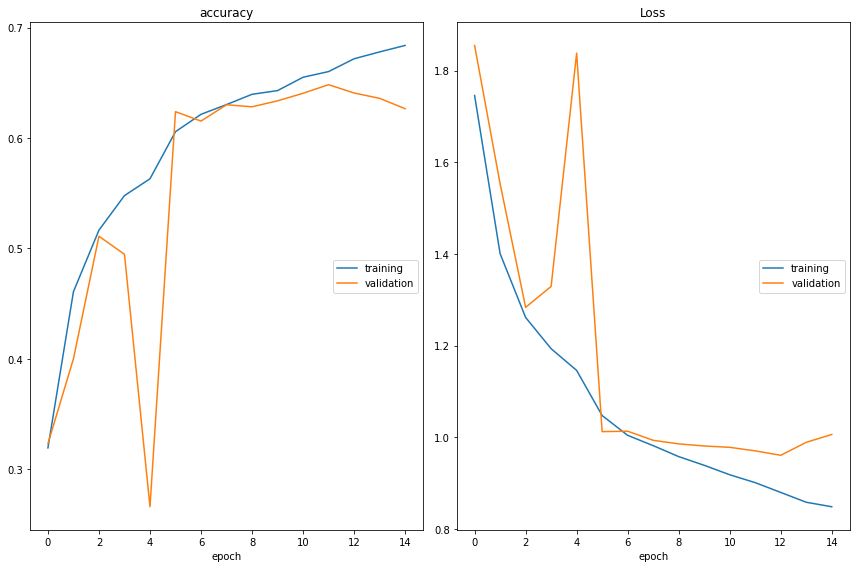

accuracy
	training         	 (min:    0.319, max:    0.684, cur:    0.684)
	validation       	 (min:    0.266, max:    0.648, cur:    0.627)
Loss
	training         	 (min:    0.848, max:    1.746, cur:    0.848)
	validation       	 (min:    0.961, max:    1.855, cur:    1.006)

Epoch 00015: saving model to model_weights.h5


In [7]:
epochs =15
training_steps = train_gen.n//train_gen.batch_size
validation_steps = validation_gen.n//validation_gen.batch_size

checkpoint =ModelCheckpoint("model_weights.h5",monitor = "val_accuracy",save_weights_only = True, mode='max',verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor = 0.1, patience =2, min_lr =0.0001, mode="auto")

callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x = train_gen,
    steps_per_epoch= training_steps,
    epochs =epochs,
    validation_data = validation_gen,
    validation_steps = validation_steps,
    callbacks =callbacks
)

## Representing Model as JSON String

In [8]:
model_json = model.to_json()
with open("model_json","w") as json_file:
    json_file.write(model_json)

## Sample Outputs

Below are some Sample Outputs <br>
To visit the web application click on : http://35.153.192.142:8080/

![Dashboard](https://user-images.githubusercontent.com/60103525/113486735-e5d5c580-94d1-11eb-8579-50a1bc07950d.png)
![happy](https://user-images.githubusercontent.com/60103525/113486747-f2f2b480-94d1-11eb-88e7-761d5fc4bd48.png)
![sad](https://user-images.githubusercontent.com/60103525/113486750-f5550e80-94d1-11eb-824e-57ddf9a66272.png)
![surprised](https://user-images.githubusercontent.com/60103525/113486759-f7b76880-94d1-11eb-8c07-cc46d4b7e939.png)
![angry](https://user-images.githubusercontent.com/60103525/113486733-e3736b80-94d1-11eb-9313-dc9fd3e80e3e.png)
